In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("./Unipol_dataset_lab3.csv")
data_f_dist = data[data["total_distance"] > 0.0]#distances equal to 0 are an outlier
print(data_f_dist.shape)
data_f_dist = data_f_dist[~((data_f_dist["total_distance"] <0.1) & (data_f_dist["road"] == "A"))]#removes 50ish trips



(1249353, 7)


In [14]:
data_f_dist.shape[0]

1249058

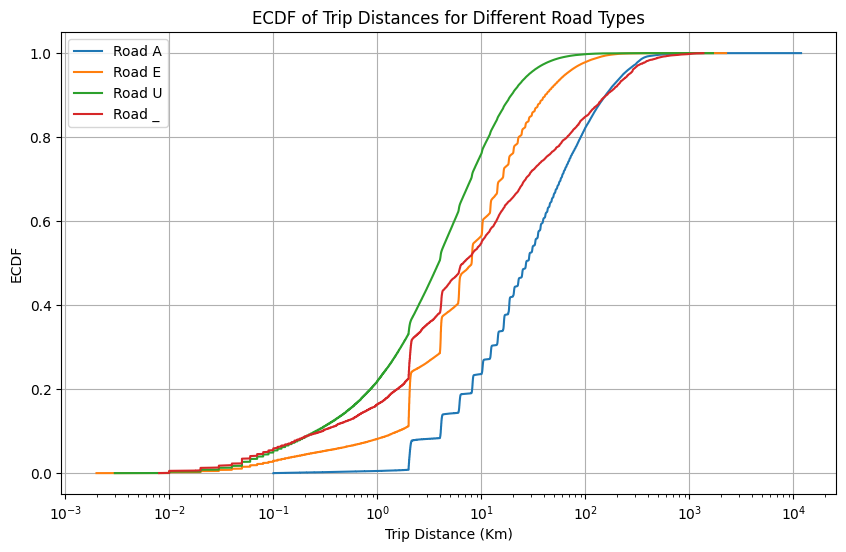

"\nFrom the ECDF plot:\n- Road type 'E' has a wider range of distances, with several long trips (up to ~14 km).\n- Road type 'U' primarily has shorter trips, with most distances under 2 km.\n- The step-like patterns in the ECDF indicate discrete trip distances.\n- Road type 'U' has more variability at shorter distances, while road 'E' includes outliers for longer trips.\n"

In [15]:
grouped = data_f_dist.groupby("road")
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

plt.figure(figsize=(10, 6))

for road, group in grouped:
    x, y = ecdf(group["total_distance"])
    plt.semilogx(x, y, label=f"Road {road}")

plt.xlabel("Trip Distance (Km)")
plt.ylabel("ECDF")
plt.title("ECDF of Trip Distances for Different Road Types")
plt.legend()
plt.grid(True)
plt.show()


"""
From the ECDF plot:
- Road type 'E' has a wider range of distances, with several long trips (up to ~14 km).
- Road type 'U' primarily has shorter trips, with most distances under 2 km.
- The step-like patterns in the ECDF indicate discrete trip distances.
- Road type 'U' has more variability at shorter distances, while road 'E' includes outliers for longer trips.
"""

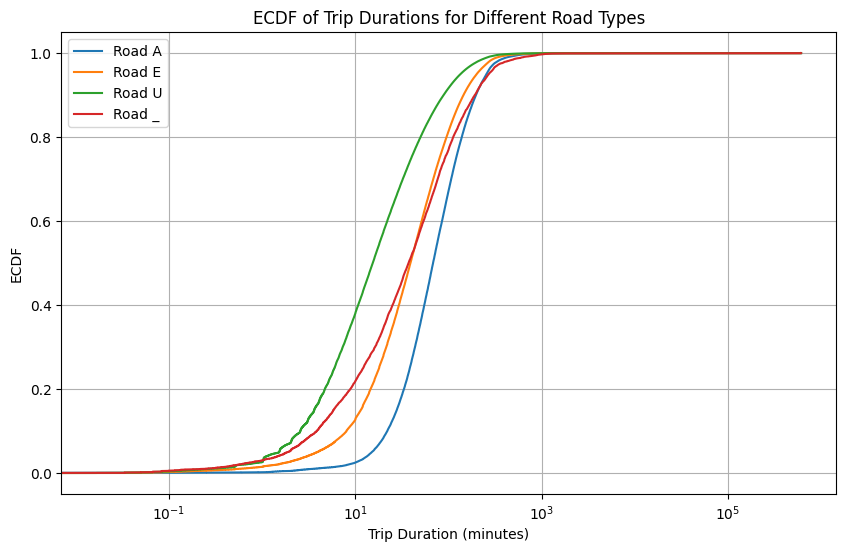

In [16]:

data_f_dist["start_time"] = pd.to_datetime(data_f_dist["start_time"])
data_f_dist["stop_time"] = pd.to_datetime(data_f_dist["stop_time"])
data_f_dist["trip_duration"] = (data_f_dist["stop_time"] - data_f_dist["start_time"]).dt.total_seconds() / 60.0 
grouped = data_f_dist.groupby("road")

plt.figure(figsize=(10, 6))
for road, group in grouped:
    x, y = ecdf(group["trip_duration"])
    plt.semilogx(x, y, label=f"Road {road}")

# Add labels, legend, and title
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("ECDF")
plt.title("ECDF of Trip Durations for Different Road Types")
plt.legend()
plt.grid(True)
plt.show()

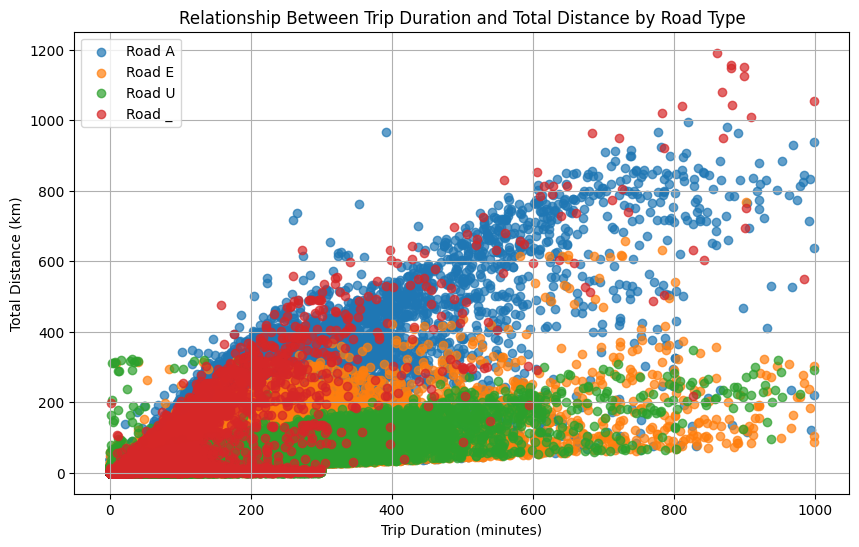

In [17]:
data_f_dist_avg = data_f_dist[~((data_f_dist["total_distance"] / (data_f_dist["trip_duration"] / 60) <= 10) & (data_f_dist["trip_duration"] > 600))]#removes 100ish trips
data_f_dist_avg = data_f_dist[~((data_f_dist["total_distance"] / (data_f_dist["trip_duration"] / 60) <= 5) & (data_f_dist["trip_duration"] > 300))]#removes 50ish trips

#data = data[data["trip_duration"] < 2880]#remove duration grate than 48 hours
data_f_dist_avg_dur = data_f_dist_avg[data_f_dist_avg['trip_duration'] < 1000]#remove duration grate than 24 hours 
plt.figure(figsize=(10, 6))
for road_type, group in data_f_dist_avg_dur.groupby("road"):
    plt.scatter(group["trip_duration"], group["total_distance"], label=f"Road {road_type}", alpha=0.7)

plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Total Distance (km)")
plt.title("Relationship Between Trip Duration and Total Distance by Road Type")
plt.legend()
plt.grid(True)
plt.show()

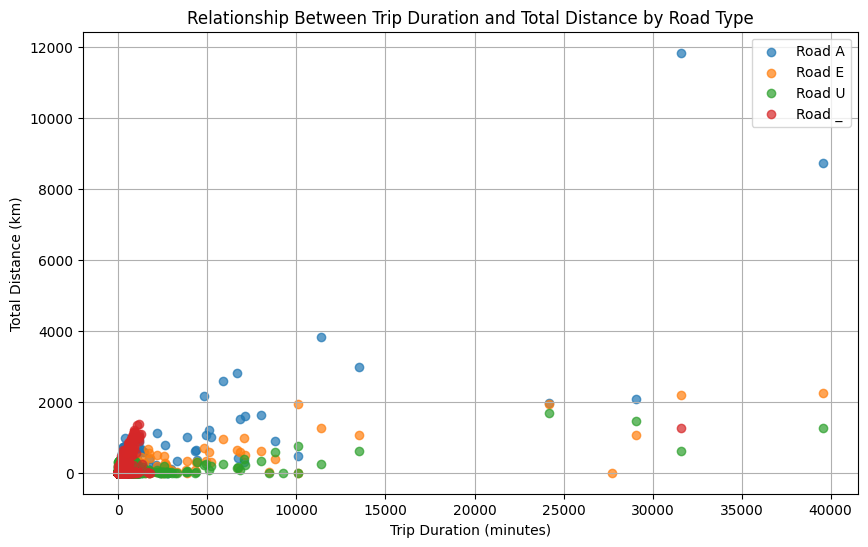

In [18]:
data_f_dist = data_f_dist[data_f_dist['trip_duration'] < 100000]#remove duration grate than 24 hours
plt.figure(figsize=(10, 6))
for road_type, group in data_f_dist.groupby("road"):
    plt.scatter(group["trip_duration"], group["total_distance"], label=f"Road {road_type}", alpha=0.7)

plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Total Distance (km)")
plt.title("Relationship Between Trip Duration and Total Distance by Road Type")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
nonFiltered_count = data.groupby(["vehicle_id", "trip_id"]).nunique().shape[0]
print(f"Number of trips before filtering: {nonFiltered_count}")

Number of trips before filtering: 966000


In [20]:
fil_dist_avg_dur_count = data_f_dist_avg_dur.groupby(["vehicle_id", "trip_id"]).nunique().shape[0]
print(f"Number of trips after filtering for average distance and duration: {fil_dist_avg_dur_count}")

Number of trips after filtering for average distance and duration: 827886


In [21]:
data_f_dist.groupby(["vehicle_id", "trip_id"]).nunique().shape[0]


828117

# Task 1

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("./Unipol_dataset_lab3.csv")
data = data[data["total_distance"] > 0.0]
data = data[~((data["total_distance"] <0.1) & (data["road"] == "A"))]

data["start_time"] = pd.to_datetime(data["start_time"])
data["stop_time"] = pd.to_datetime(data["stop_time"])
data["trip_duration"] = (data["stop_time"] - data["start_time"]).dt.total_seconds() / 60.0 

data = data[~((data["total_distance"] / (data["trip_duration"] / 60) <= 10) & (data["trip_duration"] > 600))]#removes 100ish trips
data = data[~((data["total_distance"] / (data["trip_duration"] / 60) <= 5) & (data["trip_duration"] > 300))]#removes 50ish trips
data = data[data['trip_duration'] < 1200]#remove duration grate than 1200 minutes, 20 hours

#Number of trips before filtering: 966000 
print(data.shape[0], data.groupby(["vehicle_id", "trip_id"]).nunique().shape[0])

1243568 827889


In [23]:


data["date"] = data["start_time"].dt.date
aggregated = data.groupby(["vehicle_id", "date"]).agg(
    number_of_trips=("trip_id", "nunique"),
    total_travel_distance=("total_distance", "sum"),
    total_driving_time=("trip_duration", "sum")
).reset_index()
aggregated["utilization_percentage"] = aggregated["total_driving_time"] / (24 * 60) * 100  # Fraction of driving time in 24 hours

aggregated["day_of_week"] = pd.to_datetime(aggregated["date"]).dt.dayofweek
aggregated['day_type'] = aggregated['day_of_week'].apply(lambda x: 'workday' if x < 5 else 'weekend/holiday')

stats = aggregated.groupby(['vehicle_id', 'day_type']).agg({
    'number_of_trips': ['mean', 'median', 'std'],
    'total_travel_distance': ['mean', 'median', 'std'],
    'utilization_percentage': ['mean', 'median', 'std']
}).reset_index()

stats.describe()

vehicle_id number_of_trips                            \
                              mean       median          std   
count  1993.000000     1993.000000  1993.000000  1990.000000   
mean    500.113899       13.594017    13.253889     5.886605   
std     288.993781       14.899269    15.270273     5.961715   
min       1.000000        1.000000     1.000000     0.000000   
25%     250.000000        7.065217     6.500000     3.160159   
50%     499.000000       11.288889    11.000000     4.683589   
75%     751.000000       17.000000    17.000000     7.065721   
max    1000.000000      412.833333   422.500000   159.748792   

      total_travel_distance                           utilization_percentage  \
                       mean       median          std                   mean   
count           1993.000000  1993.000000  1990.000000            1993.000000   
mean             345.678380   340.515997   176.161064              68.212871   
std              158.870941   182.716961   102.640283              25.925898   
min                0.047500     0.050000     0.007071               0.193287   
25%              248.826111   234.470000   105.249495              52.657022   
50%              308.608889   302.635000   150.857304              68.072857   
75%              418.651000   429.730000   221.605952              84.152443   
max              960.639773  1204.620000   712.520596             178.483410   

                                 
            median          std  
count  1993.000000  1990.000000  
mean     68.383332    31.180851  
std      29.781183    12.732440  
min       0.170718     0.057273  
25%      51.225694    22.302934  
50%      68.793403    29.925457  
75%      86.982639    38.743430  
max     173.126157    99.959494

c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nepim\App

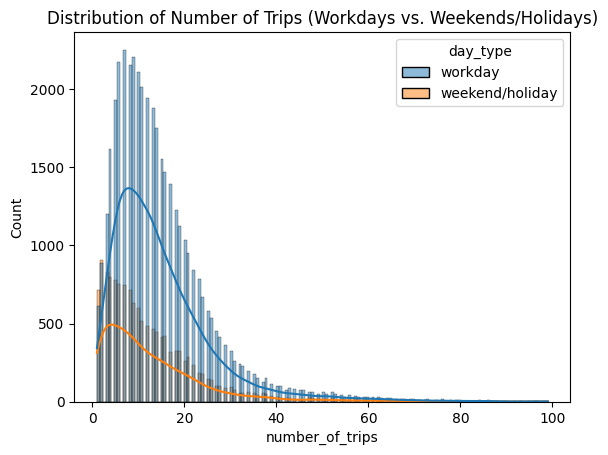

In [24]:
import seaborn as sns
hist_data = aggregated[aggregated['number_of_trips'] < 100]
sns.histplot(data=hist_data, x='number_of_trips', hue='day_type', kde=True)
plt.title('Distribution of Number of Trips (Workdays vs. Weekends/Holidays)')
plt.show()

c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nepim\App

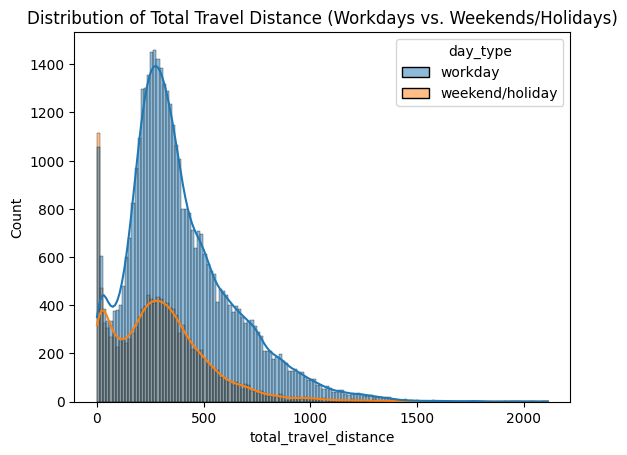

In [25]:
sns.histplot(data=hist_data, x='total_travel_distance', hue='day_type', kde=True)
plt.title('Distribution of Total Travel Distance (Workdays vs. Weekends/Holidays)')
plt.show()

c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nepim\App

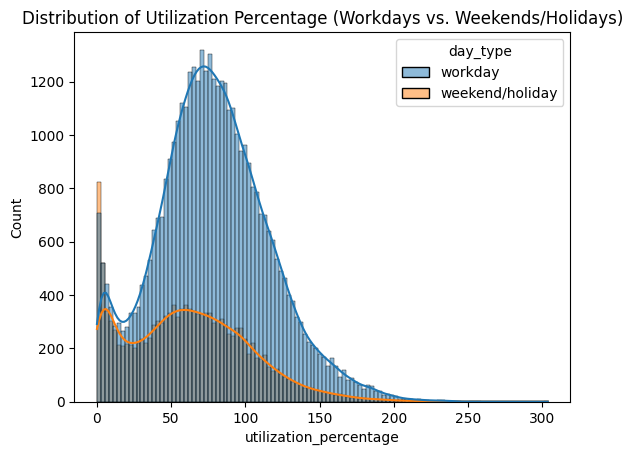

In [26]:
sns.histplot(data=hist_data, x='utilization_percentage', hue='day_type', kde=True)
plt.title('Distribution of Utilization Percentage (Workdays vs. Weekends/Holidays)')
plt.show()

KeyError: 'is_weekend'

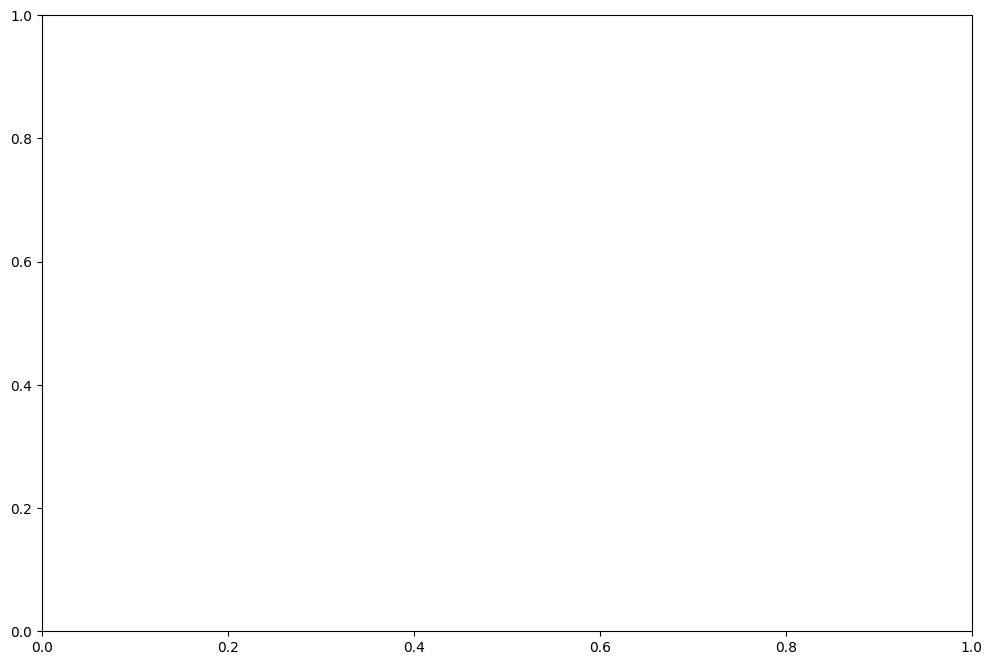

In [27]:
fig, ax = plt.subplots(figsize=(12, 8))
workday_data = aggregated[~aggregated["is_weekend"]].groupby("vehicle_id")["total_travel_distance"].mean()
weekend_data = aggregated[aggregated["is_weekend"]].groupby("vehicle_id")["total_travel_distance"].mean()
weekend_data = weekend_data.reindex(aggregated["vehicle_id"].unique(), fill_value=0)
workday_data = workday_data.reindex(aggregated["vehicle_id"].unique(), fill_value=0)
workday_data[0:10].plot(kind="bar", color="blue", alpha=0.6, position=1, width=0.4, label="Workdays", ax=ax)
weekend_data[0:10].plot(kind="bar", color="orange", alpha=0.6, position=0, width=0.4, label="Weekends", ax=ax)

ax.set_title("Comparison of Travel Distances on Workdays vs Weekends (Sampled Data)")
ax.set_ylabel("Average Total Distance (km)")
ax.set_xlabel("Vehicle ID")
ax.legend()
plt.tight_layout()
plt.show()

In [13]:
vehicles_higher_weekdays = (workday_data > weekend_data).sum()
total_vehicles = len(workday_data)
percentage_higher_weekdays = (vehicles_higher_weekdays / total_vehicles) * 100

print(f"Percentage of vehicles with higher average distance on weekdays: {percentage_higher_weekdays:.2f}%")


Percentage of vehicles with higher average distance on weekdays: 64.96%


In [14]:
workday_data[630]

293.6388372093023

In [15]:
weekend_data[630]

192.43866666666665

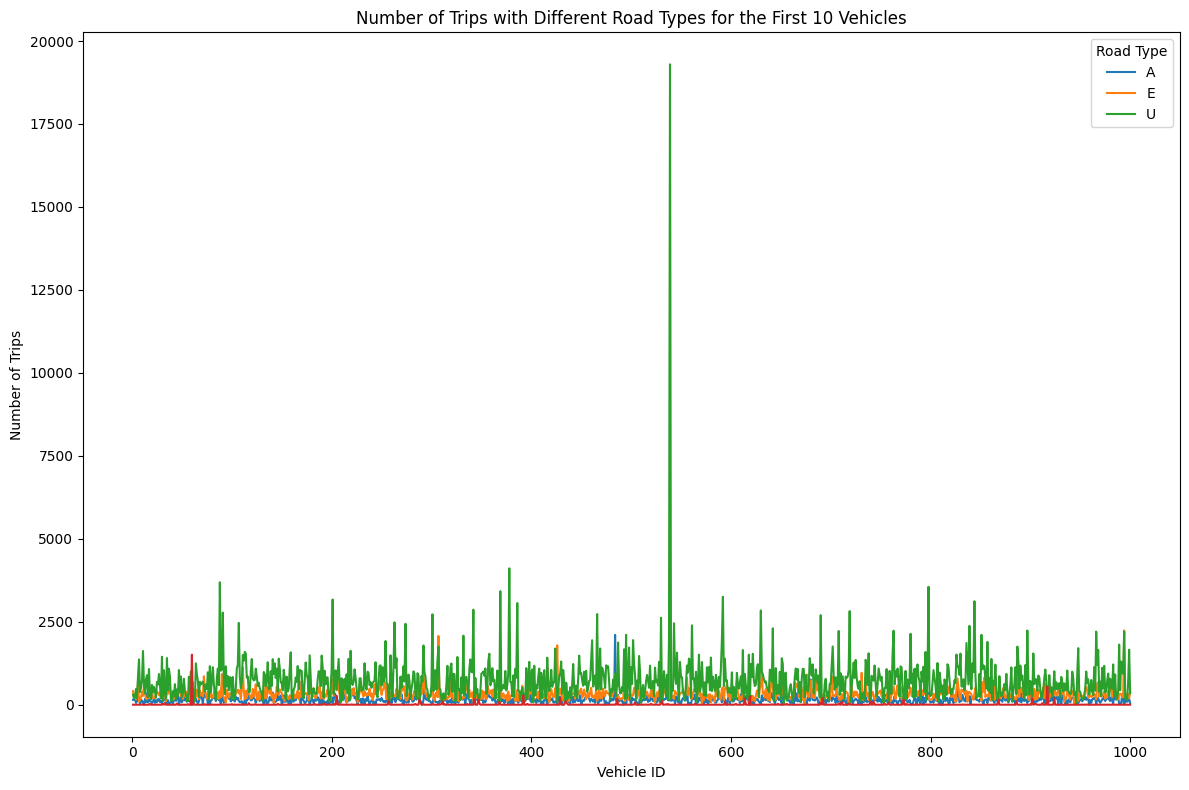

In [29]:
#B
vehicles = data[data["vehicle_id"].isin(data["vehicle_id"].unique())] #[:1000]
road_type_counts = vehicles.groupby(["vehicle_id", "road"]).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(12, 8))
for road_type in road_type_counts.columns:
    ax.plot(road_type_counts.index, road_type_counts[road_type], label=road_type)

    ax.set_title("Number of Trips with Different Road Types for the First 10 Vehicles")
    ax.set_ylabel("Number of Trips")
    ax.set_xlabel("Vehicle ID")
    ax.legend(title="Road Type")
plt.tight_layout()
plt.show()

Cluster A: [484]
number of vehicle for cluster A: 1
Cluster E: [1, 2, 3, 5, 12, 13, 19, 24, 29, 31, 39, 40, 42, 44, 46, 48, 50, 54, 55, 56, 61, 62, 63, 72, 73, 77, 83, 84, 100, 102, 103, 130, 131, 134, 146, 154, 161, 171, 172, 180, 197, 198, 209, 211, 218, 230, 245, 246, 256, 257, 258, 261, 266, 267, 268, 279, 284, 285, 289, 297, 307, 310, 313, 314, 324, 325, 329, 337, 348, 356, 364, 381, 389, 391, 392, 394, 396, 402, 404, 409, 411, 415, 426, 434, 436, 440, 446, 465, 479, 483, 496, 499, 505, 507, 510, 513, 529, 531, 535, 537, 540, 548, 552, 554, 564, 566, 602, 605, 613, 616, 617, 638, 641, 643, 646, 648, 650, 653, 656, 657, 658, 662, 670, 676, 689, 691, 693, 697, 698, 714, 720, 721, 730, 731, 734, 740, 746, 753, 758, 761, 769, 773, 776, 783, 785, 790, 796, 808, 813, 816, 820, 822, 846, 848, 850, 862, 867, 868, 873, 878, 882, 894, 896, 911, 912, 913, 918, 922, 930, 933, 941, 951, 952, 953, 954, 963, 979, 981, 984, 986, 987, 994, 995, 996, 997, 1000]
number of vehicle for cluster E: 186


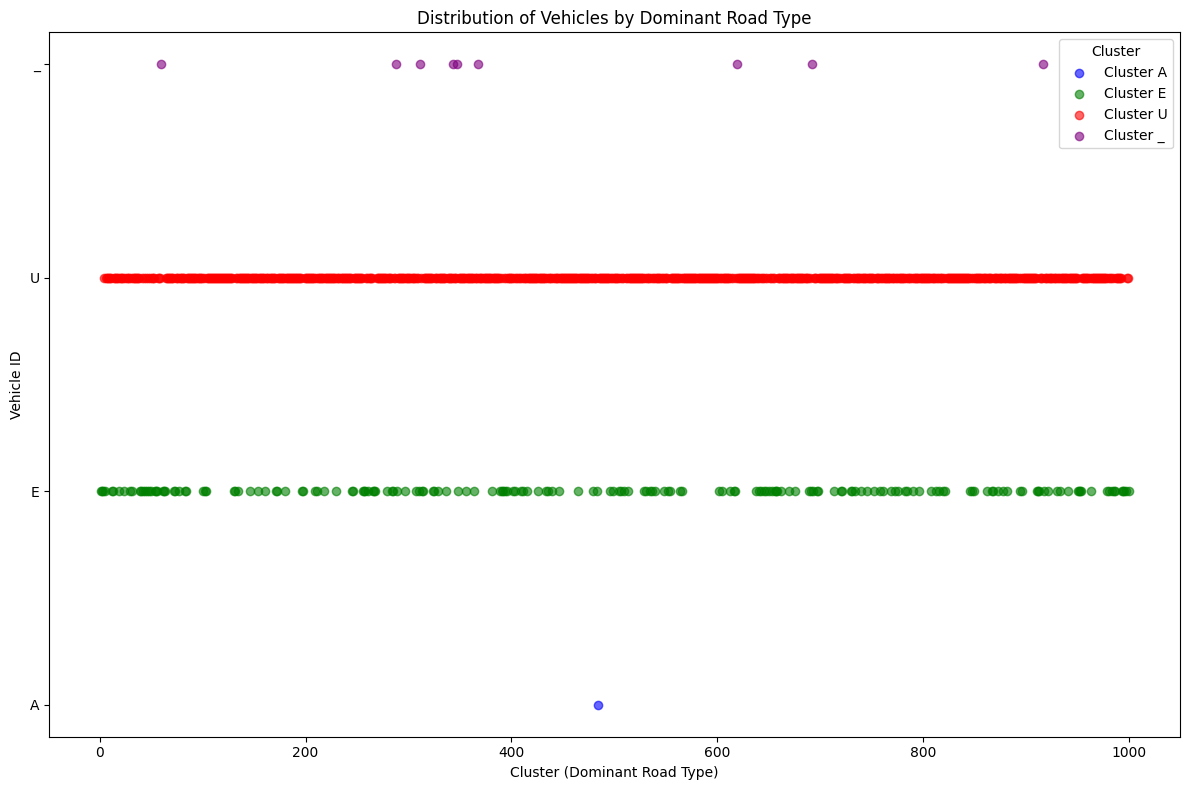

In [35]:
# C
road_type_counts = data.groupby(["vehicle_id", "road"]).size().unstack(fill_value=0)

# Determine the dominant road type for each vehicle
dominant_road_type = road_type_counts.idxmax(axis=1)

# Create clusters based on the dominant road type
clusters = {road_type: [] for road_type in road_type_counts.columns}
for vehicle_id, road_type in dominant_road_type.items():
    clusters[road_type].append(vehicle_id)

# Print the clusters
for road_type, vehicle_ids in clusters.items():
    print(f"Cluster {road_type}: {vehicle_ids}")
    print(f"number of vehicle for cluster {road_type}: {np.size(vehicle_ids)}")
# Plot the clusters
fig, ax = plt.subplots(figsize=(12, 8))
colors = {'A': 'blue', 'E': 'green', 'U': 'red', '_': 'purple'}
for road_type, vehicle_ids in clusters.items():
    for vehicle_id in vehicle_ids:
        ax.scatter(vehicle_id, road_type, color=colors[road_type], label=f"Cluster {road_type}" if vehicle_id == vehicle_ids[0] else "", alpha=0.6)

ax.set_title("Distribution of Vehicles by Dominant Road Type")
ax.set_ylabel("Vehicle ID")
ax.set_xlabel("Cluster (Dominant Road Type)")
ax.legend(title="Cluster")
plt.tight_layout()
plt.show()



In [28]:
from sklearn.cluster import KMeans

# Example: cluster vehicles based on average # of trips/day, avg distance/day, fraction of trips on road 'A', etc.
vehicle_agg = (
    data.groupby("vehicle_id")
    .agg(
        avg_trips_per_day=("trip_id", lambda x: x.nunique() / ( (data["date"].max() - data["date"].min()).days + 1 )),
        avg_distance_per_day=("total_distance", lambda x: x.sum()   / ( (data["date"].max() - data["date"].min()).days + 1 )),
        fraction_road_A=("road", lambda x: np.mean(x == "A")),
        fraction_road_U=("road", lambda x: np.mean(x == "U")),
        fraction_road_E=("road", lambda x: np.mean(x == "E")),
    )
)

# K-Means with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
vehicle_agg["cluster"] = kmeans.fit_predict(vehicle_agg)

print(vehicle_agg.head(10))


c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


            avg_trips_per_day  avg_distance_per_day  fraction_road_A  \
vehicle_id                                                             
1                    1.055670             54.675518         0.173256   
2                    0.585567             69.839629         0.256781   
3                    0.777320             72.234994         0.231190   
4                    0.981443             30.013979         0.075472   
5                    0.595876             71.547485         0.208413   
6                    1.952577             56.204386         0.123804   
7                    2.820619             29.781278         0.137626   
8                    0.785567             36.102412         0.051237   
9                    1.082474             34.237505         0.167832   
10                   1.672165             29.729938         0.096261   

            fraction_road_U  fraction_road_E  cluster  
vehicle_id                                             
1                  0.35

In [29]:
print("Cluster centers:")
print(kmeans.cluster_centers_)
cluster_profiles = vehicle_agg.groupby("cluster").mean()
print(cluster_profiles)


Cluster centers:
[[ 1.91624666 34.19045633  0.10672655  0.63981633  0.24962052]
 [ 1.01077048 74.63873117  0.21973982  0.35081449  0.39465651]
 [ 1.41251359 53.82338527  0.19102547  0.42058809  0.36887921]]
         avg_trips_per_day  avg_distance_per_day  fraction_road_A  \
cluster                                                             
0                 1.916247             34.190456         0.106727   
1                 1.010770             74.638731         0.219740   
2                 1.412514             53.823385         0.191025   

         fraction_road_U  fraction_road_E  
cluster                                    
0               0.639816         0.249621  
1               0.350814         0.394657  
2               0.420588         0.368879  


In [30]:
cluster_names = {
    0: "Urban Short Trips",
    1: "Highway Long Distances",
    2: "Frequent Commuters"
}




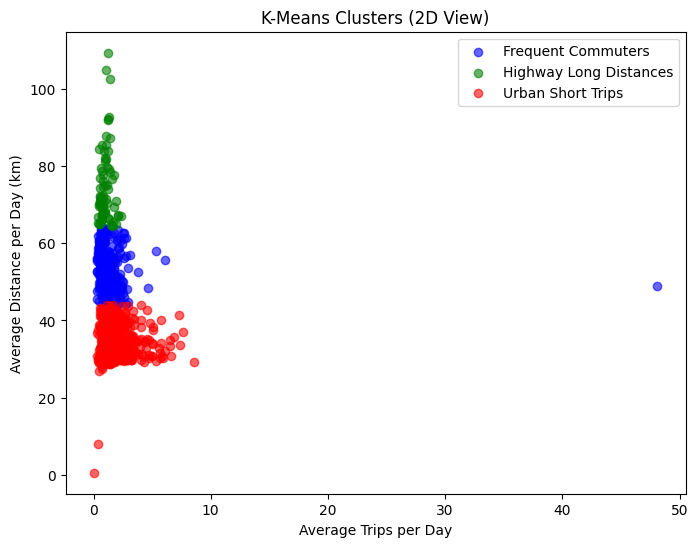

In [31]:
#Plot the clusters
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
colors = {0: "red", 1: "green", 2: "blue"}  # or any color map

for cluster_id in vehicle_agg["cluster"].unique():
    subset = vehicle_agg[vehicle_agg["cluster"] == cluster_id]
    ax.scatter(
        subset["avg_trips_per_day"],
        subset["avg_distance_per_day"],
        c=colors[cluster_id],
        label=cluster_names[cluster_id],
        alpha=0.6
    )

ax.set_xlabel("Average Trips per Day")
ax.set_ylabel("Average Distance per Day (km)")
ax.set_title("K-Means Clusters (2D View)")
ax.legend()
plt.show()


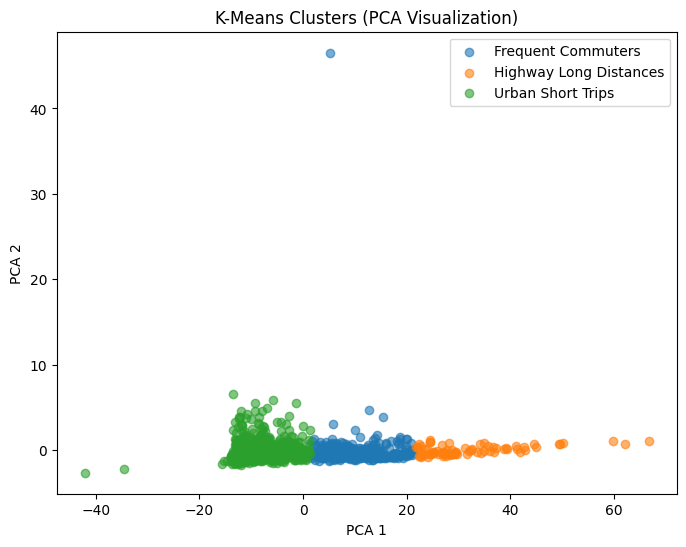

In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = vehicle_agg[["avg_trips_per_day", "avg_distance_per_day", 
                 "fraction_road_A", "fraction_road_U", "fraction_road_E"]]

pca_result = pca.fit_transform(X)
vehicle_agg["pca1"] = pca_result[:, 0]
vehicle_agg["pca2"] = pca_result[:, 1]

fig, ax = plt.subplots(figsize=(8, 6))
for cluster_id in vehicle_agg["cluster"].unique():
    subset = vehicle_agg[vehicle_agg["cluster"] == cluster_id]
    ax.scatter(subset["pca1"], subset["pca2"], 
               label=cluster_names[cluster_id], alpha=0.6)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_title("K-Means Clusters (PCA Visualization)")
ax.legend()
plt.show()


# Task 2

1. Tesla model 3 range: 420km
2. BMW iX xDrive40 range: 360km
3. Citroen e-C3  range: 260km



Evaluation Metrics
1. Percentage of Feasible Trips 
2. Energy Consumption per 100 km
3. Charging time

In [34]:
import json

cars = {
  "cars": {
    "Tesla Model 3": {
      "cost": 40990, #EUR Germany
      "range_km": 420,
      "evaluation_metrics": {
        "energy_consumption_per_100_km": 137, #Wh/km
        "charging_time": 6
      },
      "performance": {
        "acceleration_0_100_kmh": "6.1 sec",
        "top_speed_kmh": 201,
        "total_power_kw": 208,
        "total_torque_nm": 420,
        "drive": "Rear"
      },
      "battery": {
        "nominal_capacity_kwh": 60.0,
        "useable_capacity_kwh": 57.5,
        "battery_type": "Lithium-ion"
      },
      "charging": {
        "home_destination": {
          "charge_port": "Type 2",
          "port_location": "Left Side - Rear",
          "charge_power_kw_ac": 11,
          "charge_time_h": "6h15m",
          "charge_speed_kmh": 68
        },
        "fast_charging": {
          "charge_port": "CCS",
          "port_location": "Left Side - Rear",
          "charge_power_max_kw_dc": 170,
          "charge_power_10_80_kw_dc": 108,
          "charge_time_min": 24,
          "charge_speed_kmh": 730
        }
      },
      "consumption": {
        "city_cold_weather_wh_km": 149,
        "highway_cold_weather_wh_km": 189,
        "combined_cold_weather_wh_km": 167,
        "city_mild_weather_wh_km": 93,
        "highway_mild_weather_wh_km": 142,
        "combined_mild_weather_wh_km": 116
      }
    },
    "BMW iX xDrive40": {
      "cost": 77300, #EUR Germany
      "range_km": 360,
      "evaluation_metrics": {
        "energy_consumption_per_100_km": 200, #Wh/km
        "charging_time": 8
      },
      "performance": {
        "acceleration_0_100_kmh": "6.1 sec",
        "top_speed_kmh": 200,
        "total_power_kw": 240,
        "total_torque_nm": 630,
        "drive": "All-Wheel Drive"
      },
      "battery": {
        "nominal_capacity_kwh": 76.6,
        "useable_capacity_kwh": 71,
        "battery_type": "Lithium-ion"
      },
      "charging": {
        "home_destination": {
          "charge_port": "Type 2",
          "port_location": "Left Side - Rear",
          "charge_power_kw_ac": 11,
          "charge_time_h": "8h",
          "charge_speed_kmh": 45
        },
        "fast_charging": {
          "charge_port": "CCS",
          "port_location": "Left Side - Rear",
          "charge_power_max_kw_dc": 150,
          "charge_power_10_80_kw_dc": 110,
          "charge_time_min": 31,
          "charge_speed_kmh": 580
        }
      },
      "consumption": {
        "city_cold_weather_wh_km": 180,
        "highway_cold_weather_wh_km": 220,
        "combined_cold_weather_wh_km": 200,
        "city_mild_weather_wh_km": 140,
        "highway_mild_weather_wh_km": 180,
        "combined_mild_weather_wh_km": 160
      }
    },
    "Citroen e-C3": {
      "cost": 23300, #EUR Germany
      "range_km": 260,
      "evaluation_metrics": {
        "energy_consumption_per_100_km": 150, #Wh/km
        "charging_time": 7
      },
      "performance": {
        "acceleration_0_100_kmh": "9.7 sec",
        "top_speed_kmh": 150,
        "total_power_kw": 100,
        "total_torque_nm": 260,
        "drive": "Front"
      },
      "battery": {
        "nominal_capacity_kwh": 50,
        "useable_capacity_kwh": 45,
        "battery_type": "Lithium-ion"
      },
      "charging": {
        "home_destination": {
          "charge_port": "Type 2",
          "port_location": "Left Side - Rear",
          "charge_power_kw_ac": 7.4,
          "charge_time_h": "7h",
          "charge_speed_kmh": 37
        },
        "fast_charging": {
          "charge_port": "CCS",
          "port_location": "Left Side - Rear",
          "charge_power_max_kw_dc": 100,
          "charge_power_10_80_kw_dc": 75,
          "charge_time_min": 30,
          "charge_speed_kmh": 520
        }
      },
      "consumption": {
        "city_cold_weather_wh_km": 160,
        "highway_cold_weather_wh_km": 200,
        "combined_cold_weather_wh_km": 180,
        "city_mild_weather_wh_km": 120,
        "highway_mild_weather_wh_km": 160,
        "combined_mild_weather_wh_km": 140
      }
    }
  }
}



task 3

+-------------------+       +-------------------+       +-------------------+
| Define EVs & Trips| ----> | Replicate Trips   | ----> | Generate Report   |
+-------------------+       +-------------------+       +-------------------+
                               |
                               v
                        +-------------------+
                        | Simulate Consumption |
                        +-------------------+

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data["start_time"] = pd.to_datetime(data["start_time"])
data["stop_time"] = pd.to_datetime(data["stop_time"])

data["trip_duration"] = (data["stop_time"] - data["start_time"]).dt.total_seconds() / 60.0
weather = "mild" #mild or cold
charging_type = "home_destination" #fast_charging or home_destination
vehicle_data = data.groupby("vehicle_id")
price_fast_charging = 0.5 #EUR per kWh
price_home_charging = 0.15 #EUR per kWh
for car, specs in cars["cars"].items():
    total_trips = 0
    feasible_trips = 0
    non_feasible = 0
    energy_consumed_100km = 0
    charge = 0
    kwh_after_trip = []
    charging_time = []
    energy_consumed = []
    distance_trips = []
    distance_vehicles = []
    energy_vehicles = []
    battery_capacity = specs["battery"]["useable_capacity_kwh"]   #  kWh 
    consumption_per_100_km = specs["evaluation_metrics"]["energy_consumption_per_100_km"]
    last_stop = ""

    for vehicle_id, trips in vehicle_data:
        remaining_kwh = battery_capacity
        total_charge_time = 0
        distance_vehicle = []
        energy_vehicle = []
        for _, trip in trips.iterrows():
            trip_duration_hours = trip["trip_duration"] / 60.0  
            total_trips += 1
            distance_km = trip["total_distance"]
            if last_stop != "":
                time_since_last_stop = (trip["start_time"] - last_stop).total_seconds()/60 #minutes 
                if time_since_last_stop > 20:
                    
                    if charging_type == "fast_charging":
                        charged_power = specs["charging"][charging_type]["charge_power_10_80_kw_dc"] * time_since_last_stop / 60 #max or not?
                        if remaining_kwh + charged_power <= battery_capacity:
                            remaining_kwh = remaining_kwh + charged_power
                            charge_time= time_since_last_stop/60
                        else:
                            charge_time = (battery_capacity - remaining_kwh)/specs["charging"][charging_type]["charge_power_10_80_kw_dc"]
                            remaining_kwh = battery_capacity
                    else:
                        charged_power = specs["charging"]["home_destination"]["charge_power_kw_ac"] * time_since_last_stop / 60
                        if remaining_kwh + charged_power <= battery_capacity:
                            remaining_kwh = remaining_kwh + charged_power
                            charge_time = time_since_last_stop/60
                        else:
                            charge_time = (battery_capacity - remaining_kwh)/specs["charging"]["home_destination"]["charge_power_kw_ac"]
                            remaining_kwh = battery_capacity
                    charging_time.append(charge_time)
                    total_charge_time += charge_time
                    
            if weather == "cold":
                if trip.road == "U":
                    consumption = specs["consumption"]["city_cold_weather_wh_km"]
                elif trip.road == "A":
                    consumption = specs["consumption"]["highway_cold_weather_wh_km"]
                else:
                    consumption = specs["consumption"]["combined_cold_weather_wh_km"]
            else:
                if trip.road == "U":
                    consumption = specs["consumption"]["city_mild_weather_wh_km"]
                elif trip.road == "A":
                    consumption = specs["consumption"]["highway_mild_weather_wh_km"]
                else:
                    consumption = specs["consumption"]["combined_mild_weather_wh_km"]

            energy_needed = (distance_km * consumption) / 1000  #  Wh in kWh
            if energy_needed > remaining_kwh:
                non_feasible = non_feasible + 1
                remaining_kwh = 0
            else:
                remaining_kwh = remaining_kwh - energy_needed
                feasible_trips = feasible_trips + 1
                energy_consumed.append(energy_needed)
                energy_vehicle.append(energy_needed)
                distance_trips.append(distance_km)
                distance_vehicle.append(distance_km)

            kwh_after_trip.append(remaining_kwh)
            last_stop = trip.stop_time
        distance_vehicles.append(sum(distance_vehicle))
        energy_vehicles.append(sum(energy_vehicle))
    
    feasible_percentage = ((feasible_trips - non_feasible) / total_trips) * 100 if total_trips > 0 else 0
    #energy_consumption_per_100km = energy_consumed_100km / total_trips if total_trips > 0 else 0
    charge_time = np.mean(total_charge_time) 
    hours, minutes = divmod(charge_time, 60)  # hours and minutes
    avg_kwh = np.mean(kwh_after_trip)
    energy_consumed_100km = np.mean(energy_consumed)/np.mean(distance_trips)*1000
    


    print(f"----------------------------------------"*3)
    print(f"Feasible trips for {car}: {feasible_percentage:.2f}%")
    #print(f"Energy consumption per 100 km for {car}: {energy_consumption_per_100km:.2f} Wh/km")
    print(f"Average charge time for {car}: {int(hours)} hours and {int(minutes)} minutes (considering only trips that needed to charge)")
    print(f"Avarage SoC after trip for {car}: {avg_kwh:.2f} kWh, Soc percentage: {avg_kwh/battery_capacity*100:.2f}%")
    print(f"Energy consumption per 100 km for {car}: {energy_consumed_100km:.2f} kWh")
    print(f"Avarage cost by buying {car} and driving {np.mean(distance_vehicles)} Km in 2 months: \n-energy: {np.mean(energy_vehicles)*price_fast_charging:.2f} EUR \n-car: {specs['cost']:.2f} EUR")
            

------------------------------------------------------------------------------------------------------------------------
Feasible trips for Tesla Model 3: 89.81%
Average charge time for Tesla Model 3: 2 hours and 20 minutes (considering only trips that needed to charge)
Avarage SoC after trip for Tesla Model 3: 41.40 kWh, Soc percentage: 72.00%
Energy consumption per 100 km for Tesla Model 3: 117.54 kWh
Avarage cost by buying Tesla Model 3 and driving 16847.15026326327 Km in 2 months: 
-energy: 990.13 EUR 
-car: 40990.00 EUR
------------------------------------------------------------------------------------------------------------------------
Feasible trips for BMW iX xDrive40: 86.46%
Average charge time for BMW iX xDrive40: 3 hours and 8 minutes (considering only trips that needed to charge)
Avarage SoC after trip for BMW iX xDrive40: 47.76 kWh, Soc percentage: 67.26%
Energy consumption per 100 km for BMW iX xDrive40: 160.11 kWh
Avarage cost by buying BMW iX xDrive40 and driving 1615

In [36]:
#e
weather = "mild"  # mild or cold
charging_type = "home_destination"  # fast_charging or home_destination
price_fast_charging = 0.5  # EUR per kWh
price_home_charging = 0.15  # EUR per kWh
def simulate_cluster(cluster_vehicle_ids, car, specs):
    total_trips = 0
    feasible_trips = 0
    non_feasible = 0
    energy_consumed_100km = 0
    charge = 0
    kwh_after_trip = []
    charging_time = []
    energy_consumed = []
    distance_trips = []
    distance_vehicles = []
    energy_vehicles = []
    battery_capacity = specs["battery"]["useable_capacity_kwh"]  # kWh
    consumption_per_100_km = specs["evaluation_metrics"]["energy_consumption_per_100_km"]
    last_stop = ""

    for vehicle_id in cluster_vehicle_ids:
        trips = data[data["vehicle_id"] == vehicle_id]
        remaining_kwh = battery_capacity
        total_charge_time = 0
        distance_vehicle = []
        energy_vehicle = []
        for _, trip in trips.iterrows():
            trip_duration_hours = trip["trip_duration"] / 60.0
            total_trips += 1
            distance_km = trip["total_distance"]
            if last_stop != "":
                time_since_last_stop = (trip["start_time"] - last_stop).total_seconds() / 60  # minutes
                if time_since_last_stop > 20:
                    if charging_type == "fast_charging":
                        charged_power = specs["charging"][charging_type]["charge_power_10_80_kw_dc"] * time_since_last_stop / 60  # max or not?
                        if remaining_kwh + charged_power <= battery_capacity:
                            remaining_kwh = remaining_kwh + charged_power
                            charge_time = time_since_last_stop / 60
                        else:
                            charge_time = (battery_capacity - remaining_kwh) / specs["charging"][charging_type]["charge_power_10_80_kw_dc"]
                            remaining_kwh = battery_capacity
                    else:
                        charged_power = specs["charging"]["home_destination"]["charge_power_kw_ac"] * time_since_last_stop / 60
                        if remaining_kwh + charged_power <= battery_capacity:
                            remaining_kwh = remaining_kwh + charged_power
                            charge_time = time_since_last_stop / 60
                        else:
                            charge_time = (battery_capacity - remaining_kwh) / specs["charging"]["home_destination"]["charge_power_kw_ac"]
                            remaining_kwh = battery_capacity
                    charging_time.append(charge_time)
                    total_charge_time += charge_time

            if weather == "cold":
                if trip.road == "U":
                    consumption = specs["consumption"]["city_cold_weather_wh_km"]
                elif trip.road == "A":
                    consumption = specs["consumption"]["highway_cold_weather_wh_km"]
                else:
                    consumption = specs["consumption"]["combined_cold_weather_wh_km"]
            else:
                if trip.road == "U":
                    consumption = specs["consumption"]["city_mild_weather_wh_km"]
                elif trip.road == "A":
                    consumption = specs["consumption"]["highway_mild_weather_wh_km"]
                else:
                    consumption = specs["consumption"]["combined_mild_weather_wh_km"]

            energy_needed = (distance_km * consumption) / 1000  # Wh in kWh
            if energy_needed > remaining_kwh:
                non_feasible = non_feasible + 1
                remaining_kwh = 0
            else:
                remaining_kwh = remaining_kwh - energy_needed
                feasible_trips = feasible_trips + 1
                energy_consumed.append(energy_needed)
                energy_vehicle.append(energy_needed)
                distance_trips.append(distance_km)
                distance_vehicle.append(distance_km)

            kwh_after_trip.append(remaining_kwh)
            last_stop = trip.stop_time
        distance_vehicles.append(sum(distance_vehicle))
        energy_vehicles.append(sum(energy_vehicle))

    feasible_percentage = ((feasible_trips - non_feasible) / total_trips) * 100 if total_trips > 0 else 0
    charge_time = np.mean(total_charge_time)
    hours, minutes = divmod(charge_time, 60)  # hours and minutes
    avg_kwh = np.mean(kwh_after_trip)
    energy_consumed_100km = np.mean(energy_consumed) / np.mean(distance_trips) * 1000

    return {
        "feasible_percentage": feasible_percentage,
        "average_charge_time": f"{int(hours)} hours and {int(minutes)} minutes",
        "average_soc_after_trip": avg_kwh,
        "soc_percentage": avg_kwh / battery_capacity * 100,
        "energy_consumption_per_100km": energy_consumed_100km,
        "average_energy_cost": np.mean(energy_vehicles) * price_home_charging,
        "car_cost": specs['cost']
    }

for road_type, vehicle_ids in clusters.items():
    print(f"Performance metrics for cluster {road_type}:")
    for car, specs in cars["cars"].items():
        metrics = simulate_cluster(vehicle_ids, car, specs)
        print(f"Car: {car}")
        print(f"Feasible trips: {metrics['feasible_percentage']:.2f}%")
        print(f"Average charge time: {metrics['average_charge_time']} (considering only trips that needed to charge)")
        print(f"Average SoC after trip: {metrics['average_soc_after_trip']:.2f} kWh, SoC percentage: {metrics['soc_percentage']:.2f}%")
        print(f"Energy consumption per 100 km: {metrics['energy_consumption_per_100km']:.2f} kWh")
        print(f"Average energy cost: {metrics['average_energy_cost']:.2f} EUR")
        print(f"Car cost: {metrics['car_cost']:.2f} EUR")
        print(f"----------------------------------------")


Performance metrics for cluster A:
Car: Tesla Model 3
Feasible trips: 78.96%
Average charge time: 4 hours and 36 minutes (considering only trips that needed to charge)
Average SoC after trip: 30.78 kWh, SoC percentage: 53.53%
Energy consumption per 100 km: 133.27 kWh
Average energy cost: 440.35 EUR
Car cost: 40990.00 EUR
----------------------------------------
Car: BMW iX xDrive40
Feasible trips: 70.58%
Average charge time: 5 hours and 36 minutes (considering only trips that needed to charge)
Average SoC after trip: 34.33 kWh, SoC percentage: 48.36%
Energy consumption per 100 km: 172.64 kWh
Average energy cost: 524.18 EUR
Car cost: 77300.00 EUR
----------------------------------------
Car: Citroen e-C3
Feasible trips: 41.11%
Average charge time: 5 hours and 39 minutes (considering only trips that needed to charge)
Average SoC after trip: 17.01 kWh, SoC percentage: 37.79%
Energy consumption per 100 km: 150.92 kWh
Average energy cost: 345.53 EUR
Car cost: 23300.00 EUR
------------------

In [35]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd


# Assuming your filtered data is in 'data'
data["start_time"] = pd.to_datetime(data["start_time"])
data["stop_time"] = pd.to_datetime(data["stop_time"])
data["trip_duration"] = (data["stop_time"] - data["start_time"]).dt.total_seconds() / 60.0

weather = "mild"
charging_type = "fast_charging"  # or "home_destination"
vehicle_data = data.groupby("vehicle_id")

price_fast_charging = 0.5  # EUR per kWh
price_home_charging = 0.15  # EUR per kWh

# This will store one row per (car_model, vehicle_id)
results_list = []  

for car_model, specs in cars["cars"].items():

    battery_capacity = specs["battery"]["useable_capacity_kwh"]
    
    # We iterate over each vehicle's trips
    for vehicle_id, trips in vehicle_data:
        total_trips = 0
        feasible_trips = 0
        non_feasible = 0
        
        energy_consumed = []  # kWh consumed per trip
        distance_trips  = []  # km per trip
        kwh_after_trip  = []  # store remaining kWh after each trip
        
        remaining_kwh   = battery_capacity
        last_stop       = None
        total_charge_time = 0.0

        # We also track total distance and total energy for cost calculations
        distance_vehicle = 0.0
        energy_vehicle   = 0.0
        
        # Sort trips by start time (just to be safe)
        trips = trips.sort_values(by="start_time")

        for _, trip in trips.iterrows():
            total_trips += 1
            distance_km = trip["total_distance"]
            
            # 1) Handle idle time & charging
            if last_stop is not None:
                time_since_last_stop = (trip["start_time"] - last_stop).total_seconds() / 60.0
                if time_since_last_stop > 20:  # threshold to start charging
                    if charging_type == "fast_charging":
                        # How many kWh can we add during this idle period?
                        charged_power = (
                            specs["charging"][charging_type]["charge_power_10_80_kw_dc"] 
                            * (time_since_last_stop / 60.0)
                        )
                        if remaining_kwh + charged_power <= battery_capacity:
                            remaining_kwh += charged_power
                            charge_time = time_since_last_stop / 60.0
                        else:
                            # only need enough time to fill up
                            needed_kwh = battery_capacity - remaining_kwh
                            charge_time = needed_kwh / specs["charging"][charging_type]["charge_power_10_80_kw_dc"]
                            remaining_kwh = battery_capacity
                    else:
                        # home_destination charging
                        charged_power = (
                            specs["charging"]["home_destination"]["charge_power_kw_ac"] 
                            * (time_since_last_stop / 60.0)
                        )
                        if remaining_kwh + charged_power <= battery_capacity:
                            remaining_kwh += charged_power
                            charge_time = time_since_last_stop / 60.0
                        else:
                            needed_kwh = battery_capacity - remaining_kwh
                            charge_time = needed_kwh / specs["charging"]["home_destination"]["charge_power_kw_ac"]
                            remaining_kwh = battery_capacity

                    total_charge_time += charge_time

            # 2) Compute consumption needed for this trip based on road & weather
            if weather == "cold":
                if trip.road == "U":
                    consumption = specs["consumption"]["city_cold_weather_wh_km"]
                elif trip.road == "A":
                    consumption = specs["consumption"]["highway_cold_weather_wh_km"]
                else:
                    consumption = specs["consumption"]["combined_cold_weather_wh_km"]
            else:  # mild
                if trip.road == "U":
                    consumption = specs["consumption"]["city_mild_weather_wh_km"]
                elif trip.road == "A":
                    consumption = specs["consumption"]["highway_mild_weather_wh_km"]
                else:
                    consumption = specs["consumption"]["combined_mild_weather_wh_km"]

            energy_needed = (distance_km * consumption) / 1000.0  # Wh → kWh

            # 3) Check feasibility
            if energy_needed > remaining_kwh:
                non_feasible += 1
                remaining_kwh = 0  # battery drained
            else:
                feasible_trips += 1
                remaining_kwh -= energy_needed
                energy_consumed.append(energy_needed)
                distance_trips.append(distance_km)
                distance_vehicle += distance_km
                energy_vehicle   += energy_needed
            
            kwh_after_trip.append(remaining_kwh)
            last_stop = trip["stop_time"]

        # 4) After finishing all trips for this vehicle with this car model:
        if total_trips > 0:
            feasible_percentage = ((feasible_trips - non_feasible) / total_trips) * 100
        else:
            feasible_percentage = 0

        avg_kwh_after_trip = np.mean(kwh_after_trip) if kwh_after_trip else battery_capacity
        avg_soc_after_trip = (avg_kwh_after_trip / battery_capacity) * 100
        avg_charging_time_hrs = total_charge_time  # in hours (since we used (x / 60.0))
        
        # Energy consumption in kWh per 100 km
        if distance_trips and np.mean(distance_trips) > 0:
            energy_consumed_100km = np.mean(energy_consumed) / np.mean(distance_trips) * 1000
        else:
            energy_consumed_100km = 0
        
        # Simple cost estimate for average vehicle usage
        # e.g., if all charging was at home price:
        energy_cost_home = energy_vehicle * price_home_charging
        # or if you want to mix with fast-charging, you'd track how many kWh were actually fast vs. home

        # Store these results in the list for final analysis
        results_list.append({
            "vehicle_id": vehicle_id,
            "car_model": car_model,
            "total_trips": total_trips,
            "feasible_trips": feasible_trips,
            "non_feasible": non_feasible,
            "feasible_percentage": feasible_percentage,
            "avg_charging_time_hrs": avg_charging_time_hrs,
            "avg_soc_after_trip": avg_soc_after_trip,
            "energy_consumption_100km": energy_consumed_100km,
            "avg_distance_2months": distance_vehicle,  # example usage
            "energy_cost_home": energy_cost_home,
            "purchase_cost": specs["cost"]
        })

# Convert results list into a DataFrame
results_df = pd.DataFrame(results_list)
results_df.head(10)


,vehicle_id,car_model,total_trips,feasible_trips,non_feasible,feasible_percentage,avg_charging_time_hrs,avg_soc_after_trip,energy_consumption_100km,avg_distance_2months,energy_cost_home,purchase_cost
0,1,Tesla Model 3,860,850,10,97.674419,31.946385,77.557169,131.243809,26264.076,517.049606,40990
1,2,Tesla Model 3,553,508,45,83.725136,38.522187,66.081095,133.805672,25488.560,511.577085,40990
2,3,Tesla Model 3,731,684,47,87.140903,35.328186,73.594660,131.187825,21700.479,427.025798,40990
3,4,Tesla Model 3,689,689,0,100.000000,13.829847,89.361155,103.908310,14556.780,226.885562,40990
4,5,Tesla Model 3,523,479,44,83.173996,36.339181,67.387213,130.946326,23135.600,454.428274,40990
5,6,Tesla Model 3,1777,1777,0,100.000000,28.894142,86.468849,114.835837,27259.127,469.548701,40990
6,7,Tesla Model 3,1693,1693,0,100.000000,13.807867,88.843012,103.250418,14443.920,223.701117,40990
7,8,Tesla Model 3,566,566,0,100.000000,17.436439,85.369294,108.754267,17509.670,285.637700,40990
8,9,Tesla Model 3,858,853,5,98.834499,18.759752,86.007822,124.343124,15830.630,295.264498,40990
9,10,Tesla Model 3,1257,1257,0,100.000000,15.184099,82.825429,113.791670,14419.020,246.114655,40990


In [36]:
# Suppose vehicle_agg has columns: ["cluster"] and the index is vehicle_id
# If 'vehicle_id' is an index in vehicle_agg, we can do:
merged_df = results_df.merge(
    vehicle_agg[["cluster"]],  # or also "cluster_label" if you have it
    how="left",
    left_on="vehicle_id",
    right_index=True
)

# Now merged_df has columns from results_df plus "cluster"
merged_df.head(10)


,vehicle_id,car_model,total_trips,feasible_trips,non_feasible,feasible_percentage,avg_charging_time_hrs,avg_soc_after_trip,energy_consumption_100km,avg_distance_2months,energy_cost_home,purchase_cost,cluster
0,1,Tesla Model 3,860,850,10,97.674419,31.946385,77.557169,131.243809,26264.076,517.049606,40990,2
1,2,Tesla Model 3,553,508,45,83.725136,38.522187,66.081095,133.805672,25488.560,511.577085,40990,1
2,3,Tesla Model 3,731,684,47,87.140903,35.328186,73.594660,131.187825,21700.479,427.025798,40990,1
3,4,Tesla Model 3,689,689,0,100.000000,13.829847,89.361155,103.908310,14556.780,226.885562,40990,0
4,5,Tesla Model 3,523,479,44,83.173996,36.339181,67.387213,130.946326,23135.600,454.428274,40990,1
5,6,Tesla Model 3,1777,1777,0,100.000000,28.894142,86.468849,114.835837,27259.127,469.548701,40990,2
6,7,Tesla Model 3,1693,1693,0,100.000000,13.807867,88.843012,103.250418,14443.920,223.701117,40990,0
7,8,Tesla Model 3,566,566,0,100.000000,17.436439,85.369294,108.754267,17509.670,285.637700,40990,0
8,9,Tesla Model 3,858,853,5,98.834499,18.759752,86.007822,124.343124,15830.630,295.264498,40990,0
9,10,Tesla Model 3,1257,1257,0,100.000000,15.184099,82.825429,113.791670,14419.020,246.114655,40990,0


In [37]:
cluster_comparison = merged_df.groupby(["cluster", "car_model"]).agg({
    "feasible_percentage": "mean",
    "avg_charging_time_hrs": "mean",
    "avg_soc_after_trip": "mean",
    "energy_consumption_100km": "mean",
    "energy_cost_home": "mean"
}).reset_index()

print(cluster_comparison)


   cluster        car_model  feasible_percentage  avg_charging_time_hrs  \
0        0  BMW iX xDrive40            97.011454              22.929453   
1        0     Citroen e-C3            91.932788              28.231372   
2        0    Tesla Model 3            97.712769              16.907137   
3        1  BMW iX xDrive40            73.802849              45.869622   
4        1     Citroen e-C3            50.425163              50.161695   
5        1    Tesla Model 3            76.882223              36.617327   
6        2  BMW iX xDrive40            85.694057              35.842037   
7        2     Citroen e-C3            67.978731              41.544238   
8        2    Tesla Model 3            88.054404              27.964389   

   avg_soc_after_trip  energy_consumption_100km  energy_cost_home  
0           80.553512                156.167416        375.901057  
1           74.115443                135.851362        308.650899  
2           82.568712                112.4061

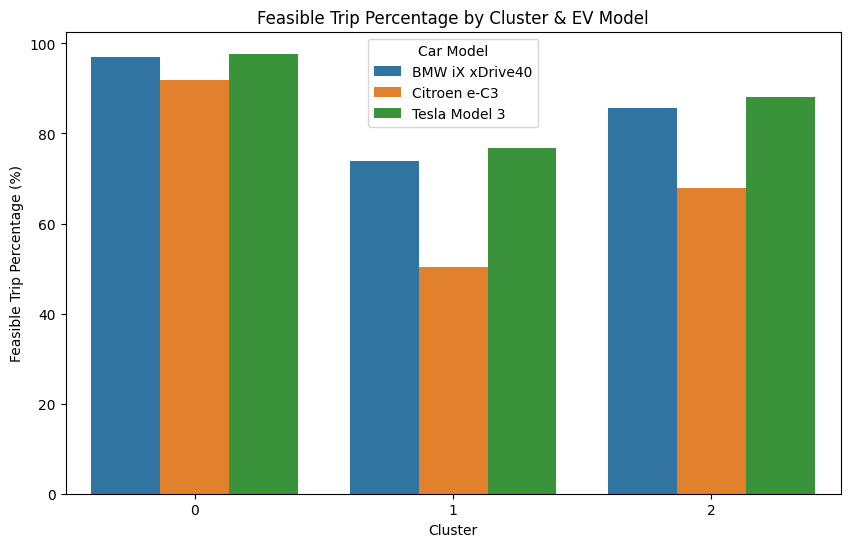

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(
    data=cluster_comparison, 
    x="cluster", 
    y="feasible_percentage", 
    hue="car_model"
)
plt.title("Feasible Trip Percentage by Cluster & EV Model")
plt.xlabel("Cluster")
plt.ylabel("Feasible Trip Percentage (%)")
plt.legend(title="Car Model")
plt.show()


## Task 6

In [39]:
def is_nighttime(dt, night_start=22, night_end=6):
    """
    Returns True if the hour of dt is between night_start and midnight
    OR between midnight and night_end.
    night_start=22, night_end=6 means 22:00-23:59 or 00:00-05:59 is night.
    """
    hour = dt.hour
    if night_start <= hour or hour < night_end:
        return True
    return False

def simulate_vehicle_trips_with_policy(trips_df, specs, weather="mild",
                                       night_start=22, night_end=6,
                                       min_stop_time_to_charge=5):
    """
    For a single vehicle, simulate trips with:
      - Home-charging only if idle time is at night (between 22 and 6).
      - Fast-charging during the day if SoC < 30%.
      - Partial charging if idle time is less than full charge time needed.
      - 'weather' can be 'cold' or 'mild' (to pick consumption).
      - 'min_stop_time_to_charge' in minutes: we skip charging if idle < X minutes.

    Returns dict with simulation stats for this vehicle.
    """
    # Sort trips in chronological order
    trips_df = trips_df.sort_values(by="start_time")

    battery_capacity = specs["battery"]["useable_capacity_kwh"]
    home_power = specs["charging"]["home_destination"]["charge_power_kw_ac"]  # kW
    fast_power = specs["charging"]["fast_charging"]["charge_power_10_80_kw_dc"]  # kW (approx)
    
    feasible_trips = 0
    non_feasible = 0
    total_trips = 0

    remaining_kwh = battery_capacity  # start full or assume full
    last_stop_time = None

    # Store for final stats
    energy_consumed_list = []
    charging_time_list   = []
    distance_list        = []

    for idx, trip in trips_df.iterrows():
        total_trips += 1
        
        # Check idle time between last trip's stop and this trip's start
        if last_stop_time is not None:
            idle_duration_min = (trip["start_time"] - last_stop_time).total_seconds() / 60.0

            if idle_duration_min >= min_stop_time_to_charge:
                # Decide charging strategy: night home-charging or day fast-charging if SoC < 30%
                start_idle = last_stop_time
                end_idle   = trip["start_time"]

                # We'll do a simplified approach: check each minute in idle
                # to see if it's night or day, and charge accordingly.
                # (You could do more precise chunk-based calculation for performance.)
                temp_current_time = start_idle
                while temp_current_time < end_idle:
                    # 1 minute increments for demonstration (could chunk by bigger steps in practice)
                    next_minute = temp_current_time + pd.Timedelta(minutes=1)
                    if next_minute > end_idle:
                        break  # no more idle

                    if is_nighttime(temp_current_time, night_start, night_end):
                        # Home-charging
                        charge_kwh_per_min = home_power / 60.0
                    else:
                        # Daytime
                        soc_percentage = (remaining_kwh / battery_capacity) * 100
                        if soc_percentage < 30:
                            # Fast-charging
                            charge_kwh_per_min = fast_power / 60.0
                        else:
                            charge_kwh_per_min = 0.0
                            
                    if charge_kwh_per_min > 0:
                        # add partial charge for 1 minute
                        remaining_kwh = min(battery_capacity, remaining_kwh + charge_kwh_per_min)
                        charging_time_list.append(1/60.0)  # 1 minute = 1/60 hour

                    temp_current_time = next_minute

        # Now attempt the trip
        distance_km = trip["total_distance"]
        
        # pick consumption depending on weather + road
        if weather == "cold":
            if trip["road"] == "U":
                consumption = specs["consumption"]["city_cold_weather_wh_km"]
            elif trip["road"] == "A":
                consumption = specs["consumption"]["highway_cold_weather_wh_km"]
            else:
                consumption = specs["consumption"]["combined_cold_weather_wh_km"]
        else:
            # mild weather
            if trip["road"] == "U":
                consumption = specs["consumption"]["city_mild_weather_wh_km"]
            elif trip["road"] == "A":
                consumption = specs["consumption"]["highway_mild_weather_wh_km"]
            else:
                consumption = specs["consumption"]["combined_mild_weather_wh_km"]

        energy_needed = (distance_km * consumption) / 1000.0  # kWh
        if energy_needed > remaining_kwh:
            # Not feasible
            non_feasible += 1
            # Optionally set remaining_kwh=0 or keep as is
            remaining_kwh = 0
        else:
            feasible_trips += 1
            remaining_kwh -= energy_needed
            energy_consumed_list.append(energy_needed)
            distance_list.append(distance_km)

        last_stop_time = trip["stop_time"]

    feasible_percentage = (feasible_trips / total_trips * 100) if total_trips > 0 else 0
    avg_charging_time_hours = np.sum(charging_time_list)
    avg_energy_consumed_kwh = np.mean(energy_consumed_list) if energy_consumed_list else 0
    avg_distance_km         = np.mean(distance_list) if distance_list else 0

    return {
        "total_trips": total_trips,
        "feasible_trips": feasible_trips,
        "feasible_percentage": feasible_percentage,
        "non_feasible": non_feasible,
        "avg_charging_time_hours": avg_charging_time_hours,
        "avg_energy_consumed_kwh": avg_energy_consumed_kwh,
        "avg_distance_km": avg_distance_km
    }

price_fast_charging = 0.5   # EUR/kWh (example)
price_home_charging = 0.15  # EUR/kWh (example)

results = []

# Group the final filtered data by vehicle
by_vehicle = data.groupby("vehicle_id")

for car_name, specs in cars["cars"].items():
    # We'll accumulate stats across ALL vehicles to get a global average
    all_feasible_trips = 0
    all_trips = 0
    all_non_feasible = 0
    all_charging_time = []
    all_energy_consumed = []
    all_distances = []

    for vehicle_id, vehicle_trips in by_vehicle:
        sim_stats = simulate_vehicle_trips_with_policy(vehicle_trips, specs, weather="mild",
                                                       night_start=22, night_end=6,
                                                       min_stop_time_to_charge=5)

        all_feasible_trips += sim_stats["feasible_trips"]
        all_trips          += sim_stats["total_trips"]
        all_non_feasible   += sim_stats["non_feasible"]
        all_charging_time.append(sim_stats["avg_charging_time_hours"])
        all_energy_consumed.append(sim_stats["avg_energy_consumed_kwh"])
        all_distances.append(sim_stats["avg_distance_km"])

    feasible_percentage = (all_feasible_trips / all_trips) * 100 if all_trips > 0 else 0
    avg_charge_time_hrs = np.mean(all_charging_time)
    avg_kwh_consumed    = np.mean(all_energy_consumed)
    avg_distance_km     = np.mean(all_distances)

    # Simplistic cost estimate for the average vehicle
    # (You could also sum actual energy usage for all trips if you stored it. 
    #  For now, we just use the average per-vehicle consumption.)
    # We'll assume all charging is at home price for nights + partial fast-charging for day, 
    # but for simplicity let's say 50/50 usage. Realistically you'd track kWh from each segment.
    # This is just a placeholder example.
    approximate_cost_energy = avg_kwh_consumed * 0.5 * price_home_charging + avg_kwh_consumed * 0.5 * price_fast_charging

    results.append({
        "car_name": car_name,
        "feasible_percentage": feasible_percentage,
        "avg_charge_time_hrs": avg_charge_time_hrs,
        "avg_kwh_consumed": avg_kwh_consumed,
        "avg_distance_km": avg_distance_km,
        "approximate_cost_energy": approximate_cost_energy,
        "purchase_cost": specs["cost"]
    })

results_df = pd.DataFrame(results)
print(results_df)


          car_name  feasible_percentage  avg_charge_time_hrs  \
0    Tesla Model 3            95.496989           559.901835   
1  BMW iX xDrive40            94.168715           562.071004   
2     Citroen e-C3            89.551677           565.286803   

   avg_kwh_consumed  avg_distance_km  approximate_cost_energy  purchase_cost  
0          2.100319        17.539246                 0.682604          40990  
1          2.748615        16.964732                 0.893300          77300  
2          2.053152        14.642723                 0.667274          23300  
